# Nouns Auction Analysis
## By [pbrianandj.eth](https://twitter.com/pbrianandj)

In [73]:
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
import numpy as np
from datetime import datetime
import pytz


import seaborn as sns; sns.set()

In [8]:
from python_graphql_client import GraphqlClient

# Instantiate the client with an endpoint.
client = GraphqlClient(endpoint="https://api.thegraph.com/subgraphs/name/nounsdao/nouns-subgraph")

# Create the query string and variables required for the request.
query = """
    {
  bids(first: 1000) {
    id,
    blockTimestamp,
    auction {
        id
    }
    noun {
      id
    },
    bidder {
      id
    },
    amount
    
  }
}
"""
# Synchronous request
data = client.execute(query=query)

In [9]:
bidders = []
for bid in data['data']['bids']:
    bidders.append(bid['bidder']['id'])

In [10]:
df = pd.DataFrame.from_dict(Counter(bidders), orient='index')

## Bid per Bidder

Text(0.5, 1.0, 'Histogram of Bids per Address')

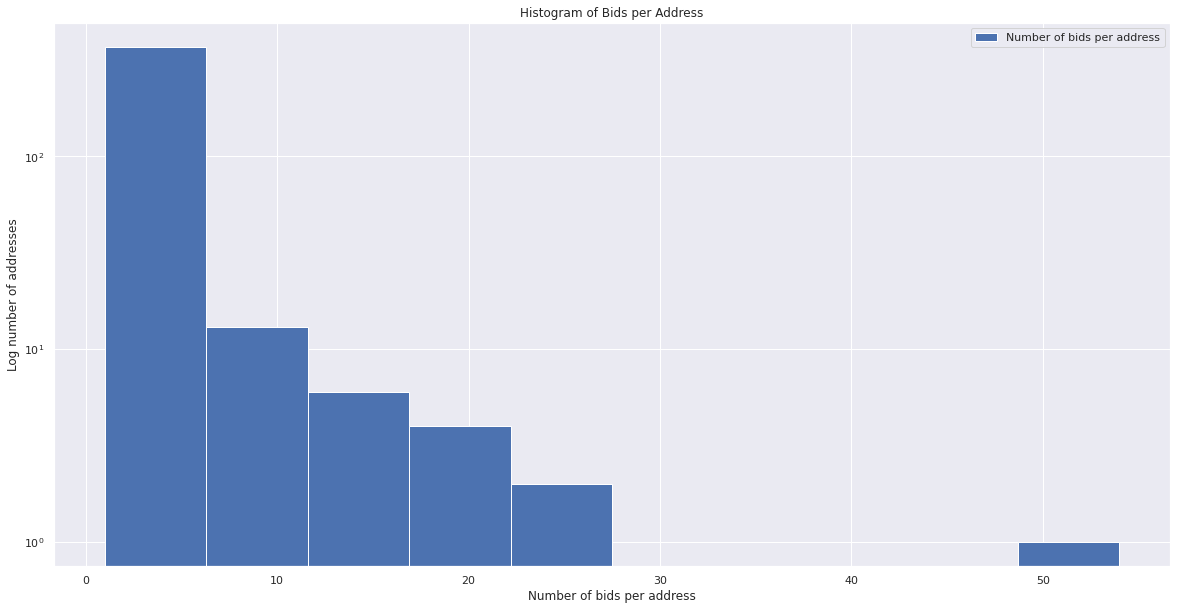

In [56]:
plt.figure(figsize=(20,10))
plt.hist(
    Counter(bidders).values(), label='Number of bids per address'
)
plt.xlabel('Number of bids per address')
plt.ylabel('Log number of addresses')
plt.legend()
plt.yscale('log')
plt.title('Histogram of Bids per Address')

## Noun price over time

In [67]:
# Create the query string and variables required for the request.
query = """
    {
  auctions(first: 1000, orderBy: id) {
    id,
    amount,
    endTime
  }
}
"""
# Synchronous request
data = client.execute(query=query)

WEI_TO_ETH_CONVERSION_FACTOR = 1000000000000000000

price = []
for auction in data['data']['auctions']:
    price.append(int(auction['amount']) / WEI_TO_ETH_CONVERSION_FACTOR)

max_auction_id = int(auction['id'])


Text(0.5, 1.0, 'Noun auction price (in ETH) over time')

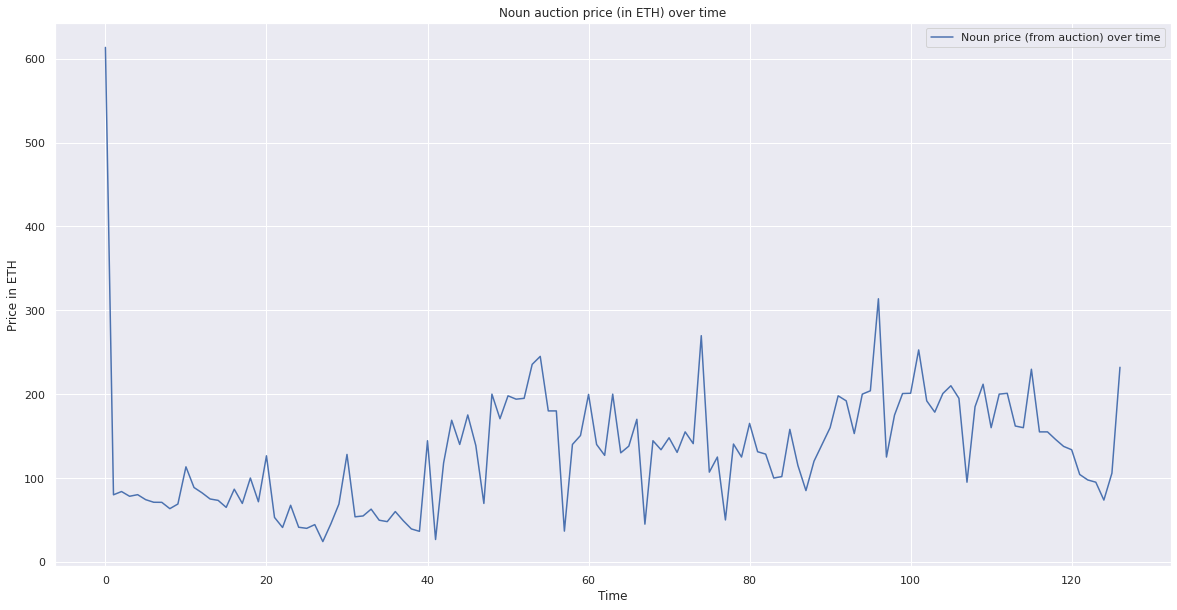

In [55]:
plt.figure(figsize=(20,10))
plt.plot(price, label='Noun price (from auction) over time')
plt.legend()
plt.ylabel('Price in ETH')
plt.xlabel('Time')
plt.title('Noun auction price (in ETH) over time')

## Noun price in ETH with first auction removed

Text(0.5, 1.0, 'Noun auction price (in ETH) over time')

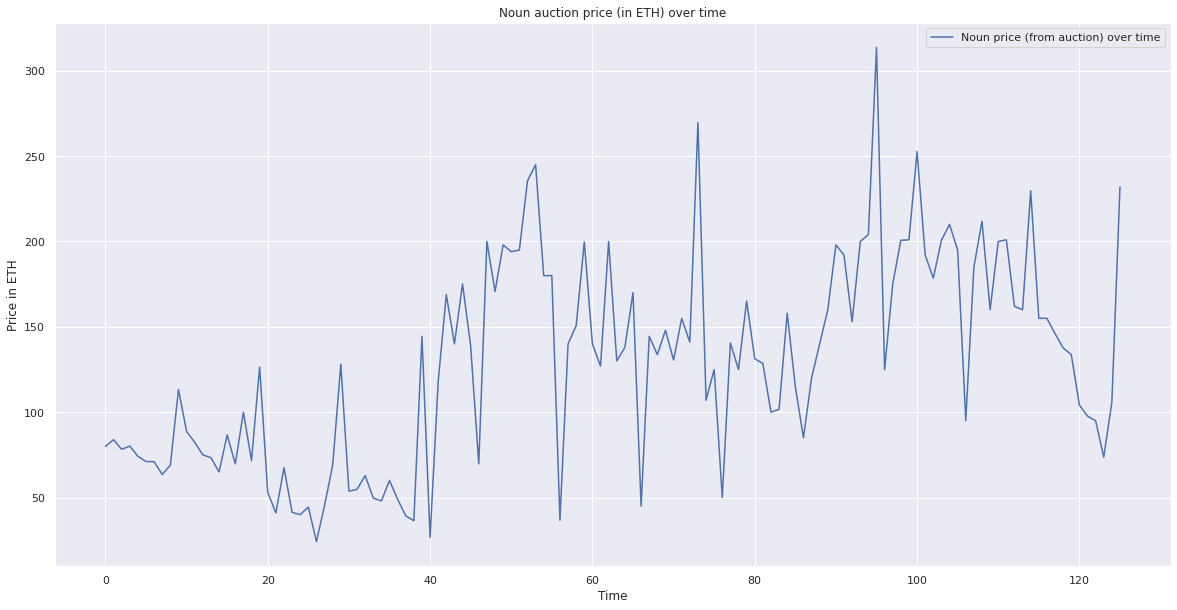

In [57]:
plt.figure(figsize=(20,10))
plt.plot(price[1:], label='Noun price (from auction) over time')
plt.legend()
plt.ylabel('Price in ETH')
plt.xlabel('Time')
plt.title('Noun auction price (in ETH) over time')

In [64]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

Text(0.5, 1.0, 'Noun auction price (in ETH) over time (7 day moving average)')

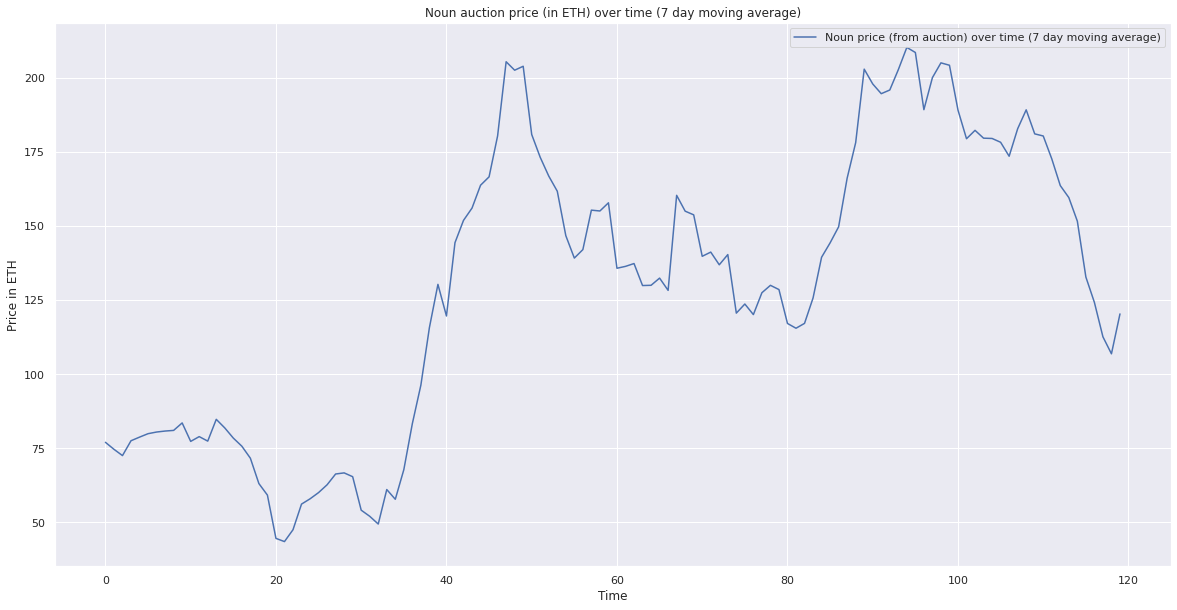

In [66]:
plt.figure(figsize=(20,10))
plt.plot(running_mean(price[1:],7), label='Noun price (from auction) over time (7 day moving average)')
plt.legend()
plt.ylabel('Price in ETH')
plt.xlabel('Time')
plt.title('Noun auction price (in ETH) over time (7 day moving average)')

Text(0.5, 1.0, 'Noun auction price (in ETH) histogram')

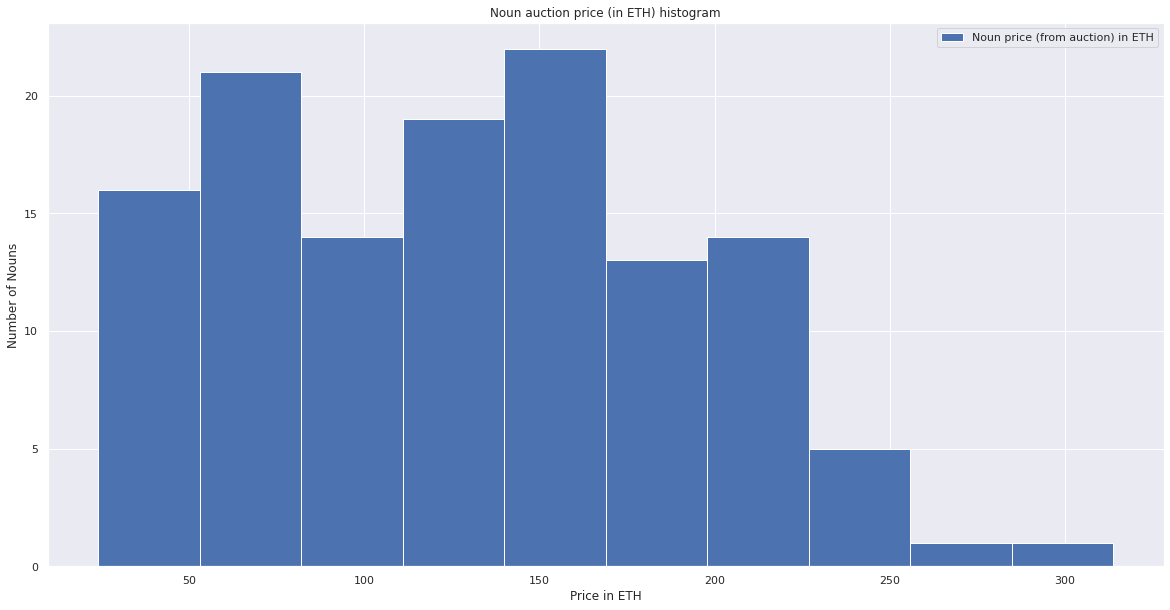

In [58]:
plt.figure(figsize=(20,10))
plt.hist(price[1:], label='Noun price (from auction) in ETH')
plt.legend()
plt.ylabel('Number of Nouns')
plt.xlabel('Price in ETH')
plt.title('Noun auction price (in ETH) histogram')

## Price vs end time of auction

In [79]:
price = []
endTime = []
for auction in data['data']['auctions']:
    price.append(int(auction['amount']) / WEI_TO_ETH_CONVERSION_FACTOR)
    endTime.append(int(auction['endTime']))
    
US_EAST_TZ = pytz.timezone("US/Eastern")

endTime = list(
    map(lambda x: US_EAST_TZ.localize(datetime.fromtimestamp(x)), endTime)
)

endTimeHour = list(
    map(lambda x: x.hour, endTime)
)

Note: We remove the first auction as that is a HUGE outlier

In [100]:
df = pd.DataFrame(list(zip(endTimeHour[1:], price[1:])), columns = ['End time hour (EST)', 'Price (ETH)'])

In [101]:
avg_price_per_hour_est = df.groupby('End time hour (EST)').mean().reset_index()

Text(0.5, 1.0, 'Avg. price in ETH of Noun auction by hour of auction end (US-ET)')

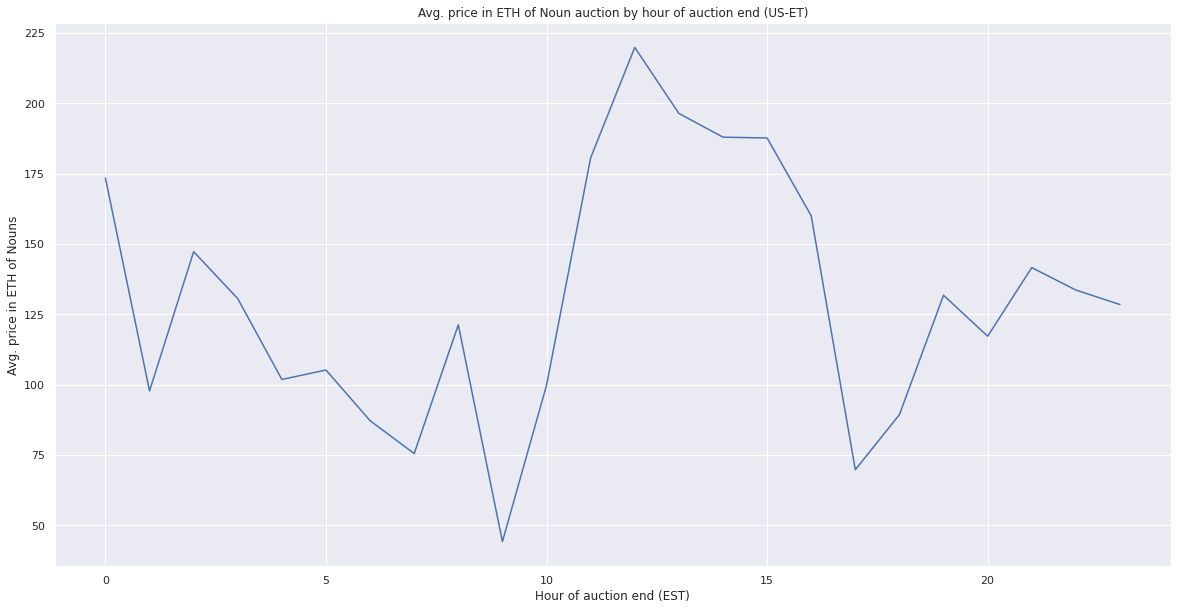

In [102]:
plt.figure(figsize=(20,10))
plt.plot(avg_price_per_hour_est['End time hour (EST)'], avg_price_per_hour_est['Price (ETH)'], label='Avg. Price (ETH) of Noun')
plt.ylabel('Avg. price in ETH of Nouns')
plt.xlabel('Hour of auction end (EST)')
plt.title('Avg. price in ETH of Noun auction by hour of auction end (US-ET)')